<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/blob/main/02_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running a series of transfer learning experiments
0. model 0 - use frature extraction transfer learning with 10% of training data without data augmentation
1. model 1 - use feature extraction transfer learning with 1% of training data with data augmentation
2. model 2 - use frature extraction transfer learning with 10% of training data with data augmentation
3. model 3 - use fine-tuning transfer learning with 10% of trainig data with data augmanation
4. model 4 - use fine-tuning transfer learning with 100% of training data with data augmentation

In [26]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [27]:
# check GPU
!nvidia-smi

Mon Mar 17 19:29:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             26W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# creating helper function

In [28]:
! wget https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py

--2025-03-17 19:29:12--  https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10129 (9.9K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2025-03-17 19:29:12 (117 MB/s) - ‘helper_functions.py.4’ saved [10129/10129]



In [29]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

# Importing dataset

In [30]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-03-17 19:29:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.4MB/s    in 8.0s    

2025-03-17 19:29:22 (20.1 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [32]:
#create the training and testing directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [25]:

# Create data inputs

IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [34]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [35]:
#see an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[9.88571396e+01 8.78571396e+01 6.78571396e+01]
   [1.01653061e+02 8.95102081e+01 6.79387741e+01]
   [1.01530609e+02 8.95306091e+01 6.75306091e+01]
   ...
   [5.53265114e+01 6.07550392e+01 5.45407753e+01]
   [5.41326523e+01 5.91326523e+01 5.31326523e+01]
   [5.17346535e+01 5.67346535e+01 5.07346535e+01]]

  [[9.75714264e+01 8.65714264e+01 6.65714264e+01]
   [9.91428604e+01 8.61428604e+01 6.71428604e+01]
   [9.96632690e+01 8.73265305e+01 6.63367310e+01]
   ...
   [5.60000000e+01 6.14285278e+01 5.52142639e+01]
   [5.53571281e+01 6.03571281e+01 5.43571281e+01]
   [5.27142143e+01 5.77142143e+01 5.17142143e+01]]

  [[9.72550964e+01 8.62550964e+01 6.62550964e+01]
   [9.66224442e+01 8.36224442e+01 6.46224442e+01]
   [9.93673477e+01 8.64285736e+01 6.72448959e+01]
   ...
   [5.60000000e+01 6.12754822e+01 5.66428337e+01]
   [5.52653008e+01 6.02653008e+01 5.56938744e+01]
   [5.32856445e+01 5.82856445e+01 5.37142143e+01]]

  ...

  [[1.09816330e+02 1.10816330e+02 1.12816330e+02]
   [1

# Model 0

In [36]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250317-192929
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 895ms/step - accuracy: 0.2993 - loss: 2.0822 - val_accuracy: 0.7484 - val_loss: 1.3076
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.7432 - loss: 1.2266 - val_accuracy: 0.8240 - val_loss: 0.8798
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8121 - loss: 0.8631 - val_accuracy: 0.8141 - val_loss: 0.7264
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8605 - loss: 0.6834 - val_accuracy: 0.8438 - val_loss: 0.6170
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8684 - loss: 0.5961 - val_accuracy: 0.8454 - val_loss: 0.5772


In [37]:
model_0.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8522 - loss: 0.5663


[0.5726659893989563, 0.857200026512146]

In [38]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [39]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

## Model 0 summary

# Model 1

In [40]:
# getting dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip") # the function is defined in helper function


--2025-03-17 19:30:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.4MB/s    in 6.8s    

2025-03-17 19:31:04 (18.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [41]:
# creating training and testing directory
train_dir_1_percent="/content/10_food_classes_1_percent/train"
test_dir_1_percent="/content/10_food_classes_1_percent/test"

In [42]:
# lets walk through the directory to check the data with the help of helper_function.py
walk_through_dir(train_dir_1_percent)
walk_through_dir(test_dir_1_percent)

There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1

creating data loaders

In [43]:
IMAGE_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)
test_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                        label_mode="categorical",
                                                                        image_size=IMAGE_SIZE,
                                                                        batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Data augmentation

tf.keras.layers.experimantal.preprocessing()

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")


be sure to pass training=True to your data_augmentation() model, otherwise the image may not augment (data augmentation only works in training mode).

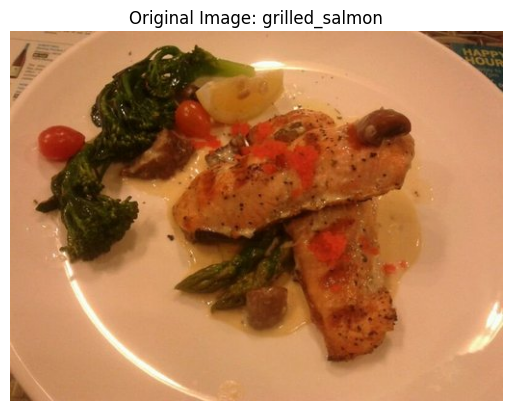

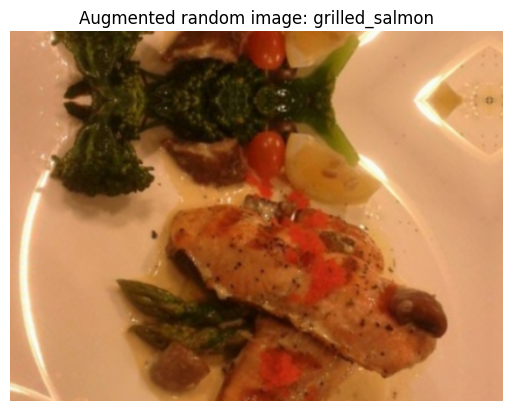

In [45]:
#view a random image and compare it with augmented image
import matplotlib.pyplot as plt
import random
import os
import matplotlib.image as mpimg

target_class=random.choice(train_data_1_percent.class_names)
target_dir=os.path.join("10_food_classes_1_percent/train",target_class)
random_img_path=os.path.join(target_dir,random.choice(os.listdir(target_dir)))
random_image=mpimg.imread(random_img_path)
plt.imshow(random_image)
plt.axis(False)
plt.title("Original Image: "+target_class)

# Augment the image
augmented_img = data_augmentation(random_image, training=True)
plt.figure()
plt.imshow(augmented_img/255.) # requires normalization after augmentation
plt.title(f"Augmented random image: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

Explanation of the Flow:
Input Layer:

The input tensor has a shape of (None, 224, 224, 3).

Data Augmentation:

The data_augmentation layer is applied to the input tensor, producing an augmented tensor of the same shape (None, 224, 224, 3).

Base Model:

The augmented tensor is passed to the base_model (EfficientNetV2B0), which outputs a tensor of shape (None, 7, 7, 1280) (assuming EfficientNetV2B0's default output shape).

Global Average Pooling:

The GlobalAveragePooling2D layer reduces the spatial dimensions to (None, 1280).

Output Layer:

A Dense layer with 10 units and softmax activation is added for classification.

Model Compilation and Training:

The model is compiled with categorical_crossentropy loss and trained using the provided dataset.

inputs (224, 224, 3) → data_augmentation → augmented tensor (224, 224, 3) → base_model → ...

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

# Data augmentation layer
data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")

# 1. Create base model with tf.keras.applications
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
print(f"Input shape: {inputs.shape}")

# 4. Apply data augmentation to the inputs
x = data_augmentation(inputs)
print(f"Augmented shape: {x.shape}")

# 5. Pass the augmented inputs to the base_model
x = base_model(x)
print(f"Base shape: {x.shape}")

# 6. Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Add a dense layer on top as an output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Create the model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",  # Fixed typo: categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),  # Fixed typo: steps_per_epoch
                              validation_data=test_data_1_percent,
                              validation_steps=int(0.25 * len(test_data_1_percent)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_feature_extractor")])

Input shape: (None, 224, 224, 3)
Augmented shape: (None, 224, 224, 3)
Base shape: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/1_percent_feature_extractor/20250317-193107
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0897 - loss: 2.3595 - val_accuracy: 0.1711 - val_loss: 2.2659
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1489 - loss: 2.2610 - val_accuracy: 0.2155 - val_loss: 2.1645
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 780ms/step - accuracy: 0.2757 - loss: 2.0252 - val_accuracy: 0.2697 - val_loss: 2.0874
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step - accuracy: 0.3732 - loss: 1.8782 - val_accuracy: 0.3257 - val_loss: 2.0182
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.4506 - loss: 1.8422 - val_accuracy: 0.3618 - val_loss: 1.9490


## Model 1 Summary

In [47]:
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [48]:
# evaluate our model on full test dataset. we only validate 25% during training
model_1_eval_results=model_1.evaluate(test_data_1_percent)
model_1_eval_results


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3808 - loss: 1.9267


[1.9296441078186035, 0.3736000061035156]

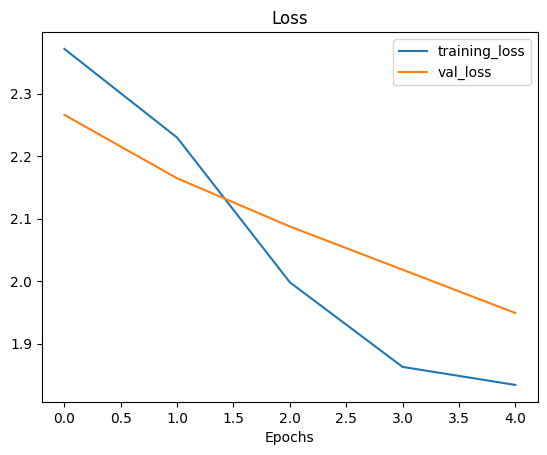

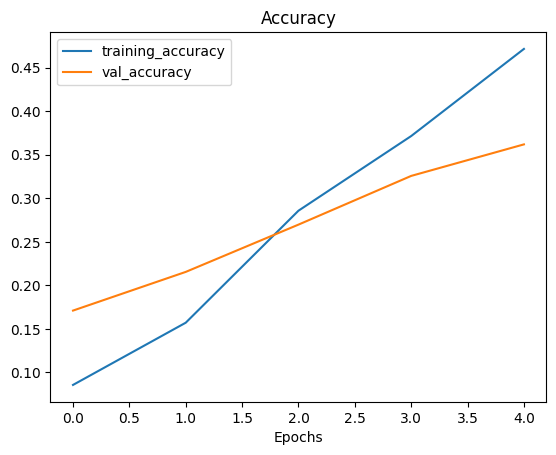

In [49]:
# lets visualize loss curves
plot_loss_curves(history=history_model_1) # defined in helper function

# Model 2

In [50]:
# Model 2
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
augmentation_layer=data_augmentation(inputs)
x=base_model(augmentation_layer,training=False)
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history=model_2.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data_10_percent,
                            validation_steps=int(0.25*len(test_data_10_percent)),
                            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extractor")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor/20250317-193148
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.1741 - loss: 2.3104 - val_accuracy: 0.5197 - val_loss: 1.7256
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.4701 - loss: 1.7130 - val_accuracy: 0.6990 - val_loss: 1.2513
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6610 - loss: 1.3212 - val_accuracy: 0.7697 - val_loss: 0.9669
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6846 - loss: 1.1417 - val_accuracy: 0.8010 - val_loss: 0.8164
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.7257 - loss: 1.0045 - val_accuracy: 0.8059 - val_loss: 0.7624


### Creating Model Checkpoint callback

In [51]:
# set checkpoint path
checkpoint_path="checkpoint/10_percent_model_checkpoint.weights.h5"
# create a model checkpoint callback that saves the model waights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       monitor='val_loss',
                                                       save_weights_only=True,
                                                       save_freq='epoch',
                                                       save_best_only=False,
                                                       verbose=1)

In [52]:
model_2_history_with_checkpoint=model_2.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=int(0.25*len(test_data_10_percent)),
                                            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extractor_2"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor_2/20250317-193229
Epoch 1/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7762 - loss: 0.9159
Epoch 1: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7760 - loss: 0.9131 - val_accuracy: 0.7829 - val_loss: 0.7058
Epoch 2/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7940 - loss: 0.8206
Epoch 2: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7937 - loss: 0.8199 - val_accuracy: 0.8191 - val_loss: 0.6486
Epoch 3/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7960 - loss: 0.7558
Epoch 3: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7967 - loss: 0.7559 - val_accuracy: 0.8289 - val_loss: 0.6059
Epoch 4/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7823 - los

### Model 0 vs Model 2

In [53]:
model_0.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8520 - loss: 0.5633


[0.5726659297943115, 0.857200026512146]

In [64]:
model_2_eval_result=model_2.evaluate(test_data_10_percent)
model_2_eval_result

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8380 - loss: 0.5509


[0.556644082069397, 0.8379999995231628]

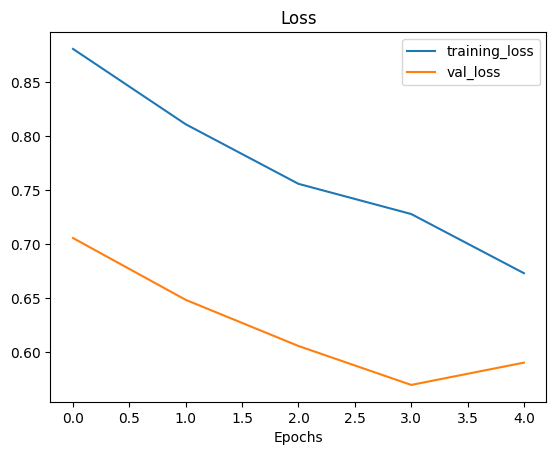

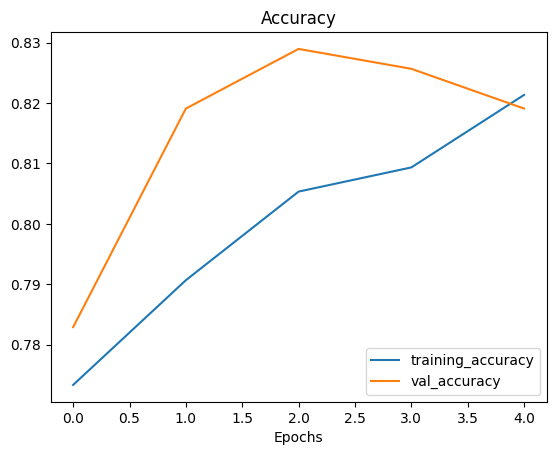

In [55]:
plot_loss_curves(history=model_2_history_with_checkpoint)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [56]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)


In [57]:
# Evaluating model 2 with loaded results
loaded_weights_model_results=model_2.evaluate((test_data_10_percent))


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8376 - loss: 0.5477


In [58]:
model_1_eval_results==loaded_weights_model_results

False

In [61]:
loaded_weights_model_results

[0.5566439032554626, 0.8379999995231628]

In [66]:
model_2_eval_result

[0.556644082069397, 0.8379999995231628]

There is slight differences in values. it is because how computer store numbers. Lets see if the values are close or not using python function

In [70]:
import numpy as np
np.isclose(np.array(model_2_eval_result),np.array(loaded_weights_model_results))

array([ True,  True])